CS4001/4042 Assignment 1
---
Part A, Q1 (15 marks)
---

>Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers. 

In [3]:
SEED = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

Define the model class.

In [7]:
class MLP(nn.Module):
    def __init__(self, no_features, no_hidden1, drop_out, no_hidden2=128, no_hidden3=128, no_labels=1):
        super(MLP, self).__init__()
        self.relu_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden1),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden1, no_hidden2),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden2, no_hidden3),
            nn.ReLU(),
            nn.Dropout(p=drop_out),
            nn.Linear(no_hidden3, no_labels),
            nn.Sigmoid()
        )

    def forward(self, x):
        logits = self.relu_stack(x)
        return logits

> Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

Split the dataset and do preprocessing. You can use the split_dataset and preprocess_dataset provided for you.

In [8]:
from common_utils import split_dataset, preprocess_dataset

df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]
df_train, y_train, df_test, y_test = split_dataset(df= df, columns_to_drop= ['filename', 'label'],
                                                   test_size= 0.3, random_state= SEED)

df_train_scaled, df_test_scaled = preprocess_dataset(df_train, df_test)

> Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 128**. Implement early stopping with patience of **3**.

In [9]:
no_epoch = 100
lr = 0.001
batch_size = 128
patience = 3

input_features = 57
hidden_depth = 128
dropout = 0.2

1. Define a Pytorch Dataset and Dataloaders.  

In [11]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_data = MyDataset(df_train_scaled, y_train)
test_data = MyDataset(df_test_scaled, y_test)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

2. Next, define the model, optimizer and loss function.

In [12]:
model = MLP(input_features, hidden_depth, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += ((pred > 0.5).float() == y).all(dim=1).sum().item()
    
    train_loss /= size
    train_correct /= size

    return train_loss, train_correct


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            pred = model(X)
            loss = loss_fn(pred, y)

            test_loss += loss.item()
            test_correct += ((pred > 0.5).float() == y).all(dim=1).sum().item()

    test_loss /= size
    test_correct /= size

    return test_loss, test_correct

In [14]:
from common_utils import EarlyStopper

early_stopper = EarlyStopper(patience=patience, min_delta=0)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []

for t in range(no_epoch):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)

    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
        print("Done!")
        break

Epoch 1: Train_accuracy: 79.07%, Train_loss: 0.004769, Test_accuracy: 81.83%, Test_loss: 0.004040
Epoch 2: Train_accuracy: 84.79%, Train_loss: 0.002990, Test_accuracy: 85.50%, Test_loss: 0.002780
Epoch 3: Train_accuracy: 89.79%, Train_loss: 0.001994, Test_accuracy: 90.33%, Test_loss: 0.002143
Epoch 4: Train_accuracy: 94.00%, Train_loss: 0.001293, Test_accuracy: 91.67%, Test_loss: 0.001747
Epoch 5: Train_accuracy: 95.07%, Train_loss: 0.001040, Test_accuracy: 93.50%, Test_loss: 0.001632
Epoch 6: Train_accuracy: 97.00%, Train_loss: 0.000699, Test_accuracy: 94.33%, Test_loss: 0.001369
Epoch 7: Train_accuracy: 97.43%, Train_loss: 0.000558, Test_accuracy: 94.33%, Test_loss: 0.001393
Epoch 8: Train_accuracy: 98.43%, Train_loss: 0.000426, Test_accuracy: 94.50%, Test_loss: 0.001170
Epoch 9: Train_accuracy: 98.64%, Train_loss: 0.000341, Test_accuracy: 94.50%, Test_loss: 0.001473
Epoch 10: Train_accuracy: 98.79%, Train_loss: 0.000331, Test_accuracy: 96.17%, Test_loss: 0.001233
Epoch 11: Train_acc

> Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.

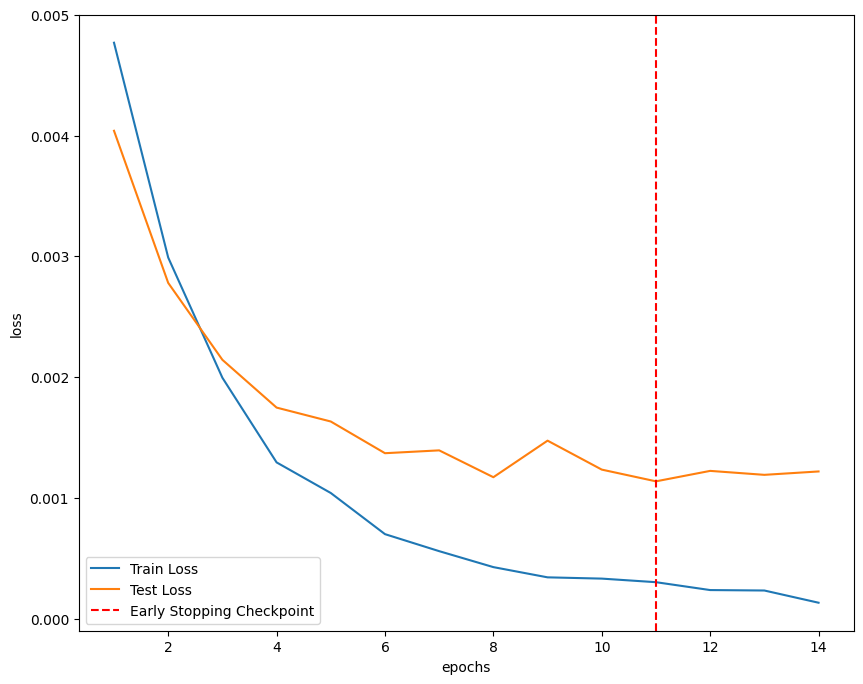

In [15]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_loss)+1),tr_loss, label='Train Loss')
plt.plot(range(1,len(te_loss)+1),te_loss,label='Test Loss')

minposs = te_loss.index(min(te_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

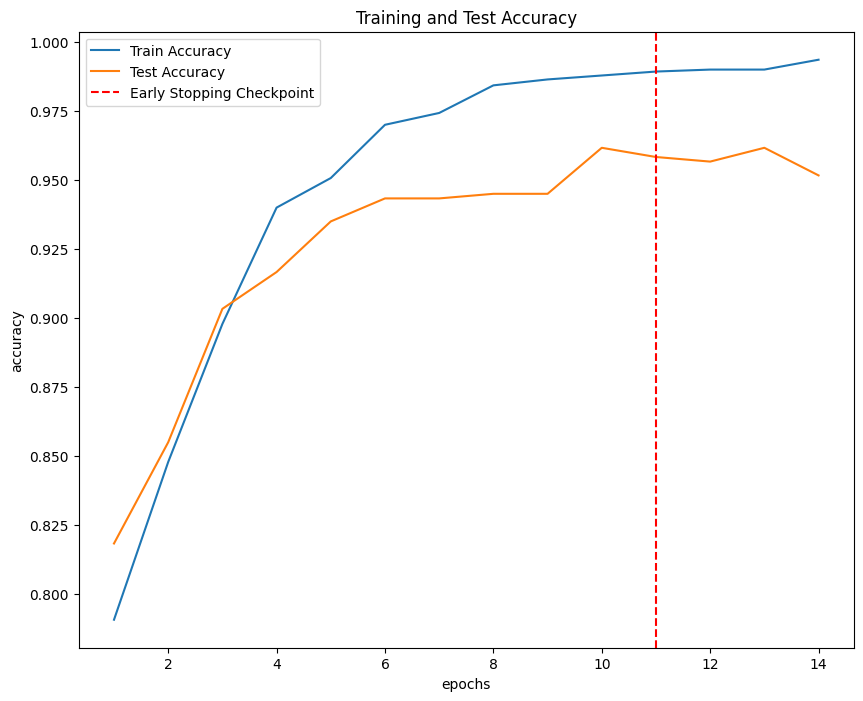

In [16]:
fig_accuracy = plt.figure(figsize=(10, 8))
plt.plot(range(1, len(tr_correct) + 1), tr_correct, label='Train Accuracy')
plt.plot(range(1, len(te_correct) + 1), te_correct, label='Test Accuracy')

plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

As number of epoch increases, the both train and test loss decreases and accuracy increases. Test loss reaches a minimum at epoch 11, which triggers early stopping to stop at epoch 14. This means that both train and test loss and accuracy plateous after epoch 11. 

Part A, Q2 (10 marks)
---

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find the optimal batch size for mini-batch gradient descent by training the neural network and evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on training partition to perform hyperparameter selection. You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

To reduce repeated code, you may need to place the network (MLP defined in QA1) in a separate file called **common_utils.py**. Import it here for Q2. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [11]:
SEED = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, split_dataset, preprocess_dataset, train_loop, test_loop
from common_utils import MLP, MyDataset, EarlyStopper

# setting seed
set_seed()

no_epoch = 100
lr = 0.001
batch_size = 128
patience = 3

input_features = 57
hidden_depth = 128
dropout = 0.2

In [12]:
df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]
df_train, y_train, df_test, y_test = split_dataset(df= df, columns_to_drop= ['filename', 'label'],
                                                   test_size= 0.3, random_state= SEED)

> Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {32, 64, 128, 256}. Next, create a table of time taken to train the network on the last epoch against different batch sizes. Finally, select the optimal batch size and state a reason for your selection. This might take a while to run, so plan your time carefully.

1. Define different folds for different batch sizes to get a dictionary of training and validation datasets. Preprocess your datasets accordingly. Please use the following name conventions:
    - X_train_scaled_dict[batch_size] is a list of the preprocessed training matrix for the different folds. 
    - X_val_scaled_dict[batch_size] is a list of the processed validation matrix for the different folds. 
    - y_train_dict[batch_size] and y_val_dict[batch_size] is a list of labels for the different folds.

In [17]:
batch_sizes = [32, 64, 128, 256]

def create_datasets(rseed, y_train, df_train):
    X_train_scaled_dict = {}
    X_val_scaled_dict = {}
    y_train_dict = {}
    y_val_dict = {}

    y_train_fold = y_train.copy()
    df_train_fold = df_train.copy()

    for batch_size in batch_sizes:
        X_train_scaled_dict[batch_size] = []
        X_val_scaled_dict[batch_size] = []
        y_train_dict[batch_size] = []
        y_val_dict[batch_size] = []
        cv = KFold(n_splits=5, shuffle=True, random_state=rseed + batch_size)

        for train_idx, test_idx in cv.split(df_train_fold, y_train_fold):
            x_train, x_val = df_train_fold.iloc[train_idx], df_train_fold.iloc[test_idx]
            y_train, y_val = y_train_fold[train_idx], y_train_fold[test_idx]

            x_train_scaled, x_val_scaled = preprocess_dataset(x_train, x_val)

            X_train_scaled_dict[batch_size].append(x_train_scaled)
            X_val_scaled_dict[batch_size].append(x_val_scaled)
            y_train_dict[batch_size].append(y_train)
            y_val_dict[batch_size].append(y_val)
    
    return X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict

2. Perform hyperparameter tuning for the different batch sizes with 5-fold cross validation. 

In [18]:
def hyperparam_tune_for_batchsize(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict):
    acc = []
    times = []
    for batch_size in batch_sizes:
        X_train = X_train_scaled_dict[batch_size]
        X_val = X_val_scaled_dict[batch_size]
        y_train = y_train_dict[batch_size]
        y_val = y_val_dict[batch_size]

        acc_ = []
        times_ = []

        for i in range(len(X_train)):

            train_data = MyDataset(X_train[i], y_train[i])
            val_data = MyDataset(X_val[i], y_val[i])

            train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

            model = MLP(input_features, hidden_depth, dropout)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.BCELoss()
            early_stopper = EarlyStopper(patience=patience, min_delta=0)

            last_time = 0

            for t in range(no_epoch):
                start = time.time()

                train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
                end = time.time()
                test_loss, test_correct = test_loop(val_dataloader, model, loss_fn)

                last_time = end - start

                if early_stopper.early_stop(test_loss):
                    break
            
            acc_.append(test_correct)
            times_.append(last_time)
        
        acc.append(sum(acc_) / len(acc_) * 100)
        times.append(sum(times_) / len(times_))

    return acc, times

In [19]:
acc = []
times = []
no_exp = 20

for exp in range(no_exp):
    X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict = create_datasets(exp, y_train, df_train)
    a, t = hyperparam_tune_for_batchsize(X_train_scaled_dict, X_val_scaled_dict, y_train_dict, y_val_dict)
    
    acc.append(a)
    times.append(t)
    print(f'Experiment {exp+1}: cv_acc {a}' )

mean_acc = np.mean(np.array(acc), axis = 0)
mean_times = np.mean(np.array(times), axis = 0)
print('Mean accuracy %s'%(mean_acc))

Experiment 1: cv_acc [97.64285714285714, 96.28571428571429, 96.64285714285714, 95.42857142857143]
Experiment 2: cv_acc [97.07142857142857, 97.21428571428572, 97.35714285714285, 95.42857142857143]
Experiment 3: cv_acc [97.57142857142857, 97.35714285714285, 97.28571428571428, 96.42857142857142]
Experiment 4: cv_acc [97.42857142857144, 97.64285714285714, 97.21428571428572, 97.14285714285712]
Experiment 5: cv_acc [97.35714285714285, 97.57142857142857, 96.85714285714285, 95.35714285714286]
Experiment 6: cv_acc [96.78571428571429, 97.5, 96.64285714285714, 96.14285714285714]
Experiment 7: cv_acc [97.0, 97.28571428571428, 96.85714285714285, 96.14285714285714]
Experiment 8: cv_acc [97.71428571428572, 97.71428571428571, 97.14285714285712, 96.07142857142857]
Experiment 9: cv_acc [97.28571428571428, 97.71428571428571, 97.0, 96.92857142857143]
Experiment 10: cv_acc [97.78571428571429, 97.71428571428572, 96.78571428571429, 97.21428571428572]
Experiment 11: cv_acc [97.28571428571428, 97.1428571428571

3. Plot scatterplot of mean cross validation accuracies on the final epoch for the different batch sizes. Limit search space to batch sizes {32, 64, 128, 256}.

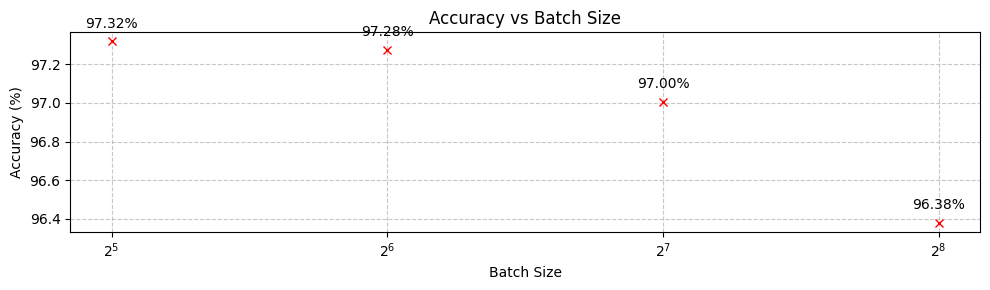

In [22]:
plt.figure(figsize=(10, 3))
plt.plot(batch_sizes, mean_acc, marker='x', linestyle='None', color='red')

plt.xlabel('Batch Size')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Batch Size')

plt.grid(True, linestyle='--', alpha=0.7)

for i, (x, y) in enumerate(zip(batch_sizes, mean_acc)):
    plt.annotate(f'{y:.2f}%', (x, y), textcoords="offset points", 
                 xytext=(0,10), ha='center')

plt.xscale('log', base=2)

plt.tight_layout()
plt.show()

4. Create a table of time taken to train the network on the last epoch against different batch sizes. 

In [23]:
df_times = pd.DataFrame({
    'Batch Size': batch_sizes,
    'Time (seconds)': mean_times
})

display(df_times)

,Batch Size,Time (seconds)
0,32,0.025369
1,64,0.014444
2,128,0.009564
3,256,0.008374


5. Select the optimal batch size and state a reason for your selection.

The optimal batchsize is 32. This is because it yields the highest accuracy, at 97.32%. Even though it is the smallest batchsize option, which means training will take a longer time, due to small dataset size, it is still a viable option

Part A, Q3 (10 marks)
---
In this question, we will find the optimal number of hidden neurons for first hidden layer of the 4-layer network (3 hidden layers, output layer) designed in Q1 and Q2.

To reduce repeated code, you may need to import the network (MLP defined in QA1) from common_utils.py. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [33]:
SEED = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, split_dataset, preprocess_dataset, train_loop, test_loop
from common_utils import MLP, MyDataset, EarlyStopper

# setting seed
set_seed()

no_epoch = 100
lr = 0.001
batch_size = 128
patience = 3

input_features = 57
hidden_depth = 128
dropout = 0.2
optimal_batch_size = 32

In [31]:
df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]
df_train, y_train, df_test, y_test = split_dataset(df= df, columns_to_drop= ['filename', 'label'],
                                                   test_size= 0.3, random_state= 10)
df_train_scaled, df_test_scaled = preprocess_dataset(df_train, df_test)

> Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}. Continue using 5-fold cross validation on training dataset. 

1. Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

In [26]:
neuron_nums = [64, 128, 256]
optimal_batch_size = 32

def hyperparam_tune_for_neurons(rseed):
    acc = []
    cv = KFold(n_splits=5, shuffle=True, random_state=rseed)

    for train_idx, test_idx in cv.split(df_train, y_train):
        df_train_scaled, _ = preprocess_dataset(df_train, df_test)
        x_train_fold, y_train_fold = df_train_scaled[train_idx], y_train[train_idx]
        x_test_fold, y_test_fold = df_train_scaled[test_idx], y_train[test_idx]

        train_data = MyDataset(x_train_fold, y_train_fold)
        test_data = MyDataset(x_test_fold, y_test_fold)

        train_dataloader = DataLoader(train_data, batch_size=optimal_batch_size, shuffle=True)
        test_dataloader = DataLoader(test_data, batch_size=optimal_batch_size, shuffle=True)

        acc_ = []

        for neuron_no in neuron_nums:
            model = MLP(input_features, neuron_no, dropout)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.BCELoss()
            early_stopper = EarlyStopper(patience=patience, min_delta=0)

            for epoch in range(no_epoch):
                train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
                test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

                if early_stopper.early_stop(test_loss):
                    break
            
            acc_.append(test_correct)
        acc.append(acc_)

    cv_acc = np.mean(np.array(acc), axis = 0)
    return cv_acc

In [27]:
no_exp = 10
accuracies = []

for exp in range(no_exp):
    accuracies.append(hyperparam_tune_for_neurons(exp))
    print(f'Experiment {exp+1}: cv_acc {accuracies[exp]}' )

mean_acc = np.mean(np.array(accuracies), axis = 0)
print('mean accuracy %s'%(mean_acc))

Experiment 1: cv_acc [0.97357143 0.97       0.97857143]
Experiment 2: cv_acc [0.97       0.97142857 0.97357143]
Experiment 3: cv_acc [0.97214286 0.97142857 0.975     ]
Experiment 4: cv_acc [0.97142857 0.97214286 0.97714286]
Experiment 5: cv_acc [0.96928571 0.97428571 0.96642857]
Experiment 6: cv_acc [0.96928571 0.97142857 0.97428571]
Experiment 7: cv_acc [0.97285714 0.97142857 0.97428571]
Experiment 8: cv_acc [0.96857143 0.97       0.97285714]
Experiment 9: cv_acc [0.97142857 0.96928571 0.97642857]
Experiment 10: cv_acc [0.97071429 0.97214286 0.975     ]
mean accuracy [0.97092857 0.97135714 0.97435714]


2. Plot the mean cross-validation accuracies on the final epoch for different numbers of hidden-layer neurons using a scatter plot. Limit the search space of the number of neurons to {64, 128, 256}.

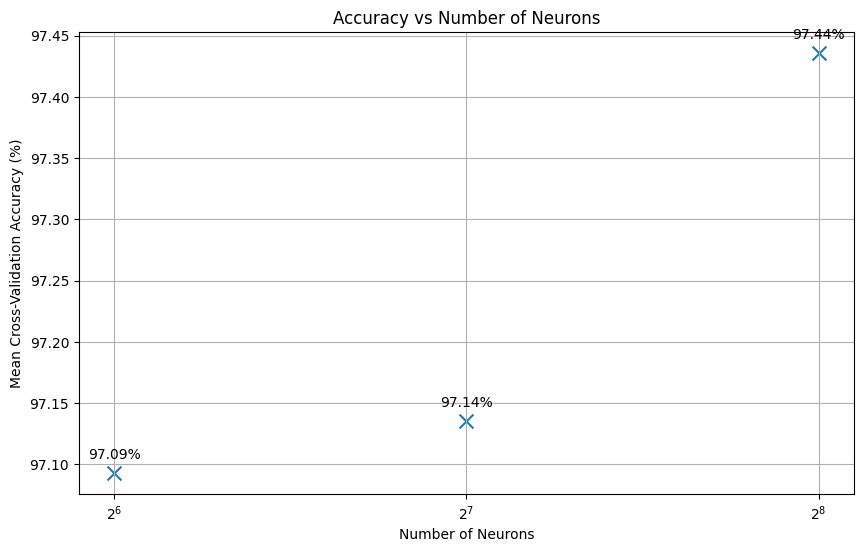

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(neuron_nums, mean_acc * 100, marker='x', linestyle='None', s=100)
plt.xlabel('Number of Neurons')
plt.ylabel('Mean Cross-Validation Accuracy (%)')
plt.title('Accuracy vs Number of Neurons')
plt.grid(True)
plt.xticks(neuron_nums)

for i, (x, y) in enumerate(zip(neuron_nums, mean_acc * 100)):
    plt.annotate(f'{y:.2f}%', (x, y), xytext=(0, 10), textcoords='offset points', ha='center')
    
plt.xscale('log', base=2)
plt.show()

> Select the optimal number of neurons for the hidden layer. State the rationale for your selection.

Hidden layer size of 256 is optimal as it yields the highest mean cross validation accuracy (97.44%) across all experiments.

> Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.
Note: use this optimal number of neurons for the rest of the experiments.

In [32]:
optimal_neuron_no = 256
model = MLP(input_features, optimal_neuron_no, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.BCELoss()
early_stopper = EarlyStopper(patience=patience, min_delta=0)

train_data = MyDataset(df_train_scaled, y_train)
test_data = MyDataset(df_test_scaled, y_test)

train_dataloader = DataLoader(train_data, batch_size=optimal_batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=optimal_batch_size, shuffle=True)

tr_loss, tr_correct = [], []
te_loss, te_correct = [], []

for t in range(no_epoch):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)

    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)

    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")

    if early_stopper.early_stop(test_loss):
        break

Epoch 1: Train_accuracy: 84.86%, Train_loss: 0.011705, Test_accuracy: 91.83%, Test_loss: 0.006157
Epoch 2: Train_accuracy: 95.43%, Train_loss: 0.003812, Test_accuracy: 94.67%, Test_loss: 0.004765
Epoch 3: Train_accuracy: 97.71%, Train_loss: 0.002214, Test_accuracy: 94.67%, Test_loss: 0.004633
Epoch 4: Train_accuracy: 98.50%, Train_loss: 0.001393, Test_accuracy: 96.00%, Test_loss: 0.003711
Epoch 5: Train_accuracy: 99.29%, Train_loss: 0.000864, Test_accuracy: 97.00%, Test_loss: 0.003504
Epoch 6: Train_accuracy: 99.14%, Train_loss: 0.000811, Test_accuracy: 96.50%, Test_loss: 0.003259
Epoch 7: Train_accuracy: 99.71%, Train_loss: 0.000412, Test_accuracy: 96.67%, Test_loss: 0.003990
Epoch 8: Train_accuracy: 99.86%, Train_loss: 0.000237, Test_accuracy: 96.67%, Test_loss: 0.003262
Epoch 9: Train_accuracy: 99.36%, Train_loss: 0.000412, Test_accuracy: 97.67%, Test_loss: 0.003274


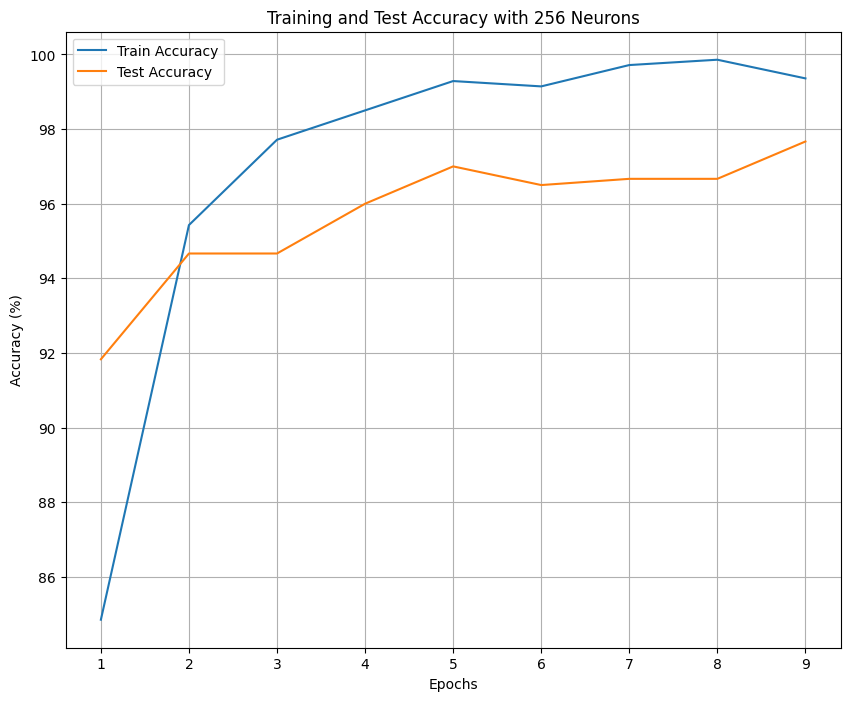

In [34]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(tr_correct)+1), [acc*100 for acc in tr_correct], label='Train Accuracy')
plt.plot(range(1,len(te_correct)+1), [acc*100 for acc in te_correct], label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title(f'Training and Test Accuracy with {optimal_neuron_no} Neurons')
plt.legend()
plt.grid(True)
plt.show()

Part A, Q4 (10 marks)
---
In this section, we will understand the utility of such a neural network for a test audio. 

Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

To reduce repeated code, you may need to import the network (MLP defined in QA1) from **common_utils.py**. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked. The following code cell will not be marked.

In [35]:
SEED = 42

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, split_dataset, preprocess_dataset, train_loop, test_loop, extract_features
from common_utils import MLP, MyDataset, EarlyStopper

# setting seed
set_seed()

no_epoch = 100
lr = 0.001
batch_size = 128
patience = 3

input_features = 57
hidden_depth = 128
dropout = 0.2
optimal_batch_size = 32
optimal_neuron_no = 256

In [36]:
df = pd.read_csv('audio_gtzan.csv')
df['label'] = df['filename'].str.split('.').str[0]
df_train, y_train, df_test, y_test = split_dataset(df= df, columns_to_drop= ['filename', 'label'],
                                                   test_size= 0.3, random_state= 10)

> Install and import shap

In [38]:
# ! pip install shap

> Preprocess 'audio_test.wav' using the function 'extract_features' in common_utils.py. Please make sure the features are stored in a pandas dataframe, using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [37]:
import IPython
IPython.display.Audio("./audio_test.wav")

In [38]:
feature_set = extract_features("./audio_test.wav")
print(feature_set)

           filename  chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0  ./audio_test.wav          0.431877         0.080057  0.056604  0.000293   

   spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0             1191.619716           40957.603068              1726.917471   

   spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean  mfcc16_var  \
0            38831.324373   2794.225223  ...    -3.746181   56.647854   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -6.391425   37.167595    -2.303412   43.675926    -8.247708    30.50214   

   mfcc20_mean  mfcc20_var  
0   -13.786491   46.941544  

[1 rows x 58 columns]


In [39]:
df_eg = pd.DataFrame.from_dict(feature_set)
size_row = 1
size_column = len(feature_set)
display(df_eg)

,filename,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,./audio_test.wav,0.431877,0.080057,0.056604,0.000293,1191.619716,40957.603068,1726.917471,38831.324373,2794.225223,...,-3.746181,56.647854,-6.391425,37.167595,-2.303412,43.675926,-8.247708,30.50214,-13.786491,46.941544


> Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. 

 1.  Preprocess to obtain the test data, save the test data as numpy array, print the shape of the test data.

In [40]:
X_test_example = df_eg.drop(columns=['filename'])

df_train_scaled, df_test_scaled = preprocess_dataset(df_train, X_test_example)

2. Do a model prediction on the sample test audio and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [41]:
# We are going to use the final model trained in Question A3.
# The model above is trained using the optimal batch size and optimal neuron no

with torch.no_grad():
    prediction = model(torch.tensor(df_test_scaled, dtype=torch.float))
    
pred_label = (prediction > 0.5).float().item()
print("pred_label:", pred_label)
print("Metal" if pred_label > 0.5 else "Blues")

pred_label: 0.0
Blues


> Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5, 
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195) 

In [42]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
import shap

features = df.drop(columns=['filename', 'label']).columns.tolist()
df_test_example = pd.DataFrame(df_test_scaled, columns=features)
background_data = torch.tensor(df_train_scaled[:100], dtype=torch.float) 

# Fit the explainer on a subset of the data
explainer = shap.DeepExplainer(model, background_data)

# Compute SHAP values for the test data
shap_values = explainer.shap_values(torch.tensor(df_test_example.values).float())

/var/folders/wn/w7mvvhb94b78hh4kwypxq2x80000gn/T/ipykernel_65227/3754113406.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_plot =shap.summary_plot(shap_values[0].T,feature_names=features,features=df_test_scaled,plot_type='bar')


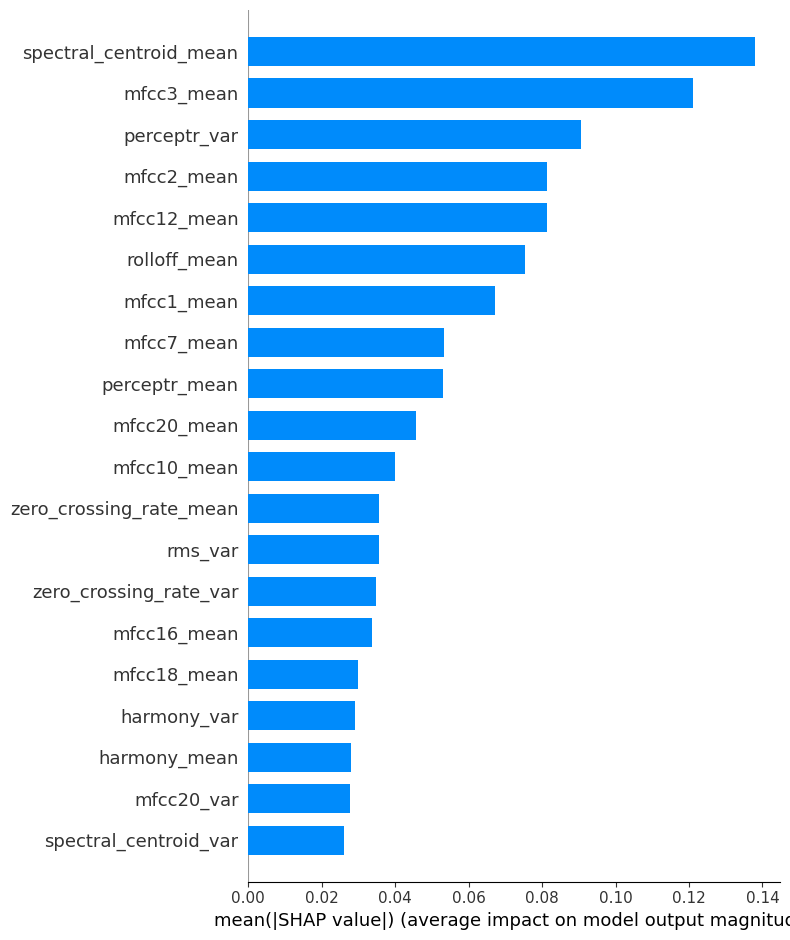

In [43]:
shap.initjs()
force_plot =shap.force_plot(explainer.expected_value[0], shap_values[0].T, features=features, figsize=(20,4))
display(force_plot)

summary_plot =shap.summary_plot(shap_values[0].T,feature_names=features,features=df_test_scaled,plot_type='bar')

From the force plot and the barplot, we can see the that the features that the highest impact on the output are:
1. spectral centroid mean
2. mfcc3_mean

And both of these two drives the output towards 0, together with a lot other features denoted as blue in the forceplot.

Meanwhile, we also have perceptr_var, mfcc7_mean, and a few other features denoted as red in the forceplot. These are the features that drives the output to 1. However, since their magnitude is smaller as compared to the blue features, the output is predicted to be 0.